In [115]:
%pylab inline
import numpy as np
from scipy.spatial.distance import cdist
import sys
sys.path.append("../")
import sgd
reload(sgd)
import theano
import theano.tensor as T
import topogen
import sklearn.datasets
import util
reload(util)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<module 'util' from '../util.pyc'>

In [155]:

reload(sgd)
N = 200
D = 2
BW = 10.0

def kern_func(X):
    translation_vectors = X.reshape((X.shape[0], 1, -1)) - X.reshape((1, X.shape[0], -1))
    euclidean_dist2 = ((translation_vectors) ** 2).sum(2) 
    kern = T.exp(-euclidean_dist2/BW)
    return kern

def make_kern_f(kern_func):
    X = T.dmatrix('X')
    return theano.function([X], kern_func(X))


def log_likelihood_func(obs, theta):
    return -(obs-theta)**2

def obs_forward(x):
    """
    go from kernel val to observations
    """
    return np.random.normal(x, 1e-2)

kern_f = make_kern_f(kern_func)

#xtrue = np.random.normal(0, 1, (N, D))
xtrue = topogen.sample_sphere(N, D) + np.random.normal(0, 0.001, (N, D))

obs = obs_forward(kern_f(xtrue))

obs_frac = 0.1
obsvalid = np.random.rand(*obs.shape) < obs_frac

xinit = np.random.normal(0, 1, (N, D))


ITERS = 1000

alpha = 0.01

res = sgd.run_sgd_full(kern_func, log_likelihood_func, 
                 xinit, obs, obsvalid, 
                 alpha=alpha, iters=ITERS, verbose=True, verbose_iter=109)



0 obj= -254.285837365 ||grad||= 36.2497412149 ||x||= 18.7245004476 0.00
109 obj= -73.6760438995 ||grad||= 4.40663966401 ||x||= 12.0768338486 0.00
218 obj= -51.4269181945 ||grad||= 4.73829644914 ||x||= 12.6631061732 0.01
327 obj= -28.0074141142 ||grad||= 4.4293603763 ||x||= 13.2939274945 0.01
436 obj= -9.91846890013 ||grad||= 3.3653802006 ||x||= 13.8120385447 0.01
545 obj= -3.38852022728 ||grad||= 1.68891568726 ||x||= 14.0430097522 0.02
654 obj= -1.49571505145 ||grad||= 1.05669427795 ||x||= 14.1231536625 0.02
763 obj= -0.569703687216 ||grad||= 0.671162705511 ||x||= 14.1674386175 0.02
872 obj= -0.382065006281 ||grad||= 0.210437814197 ||x||= 14.1845174806 0.03
981 obj= -0.361154395582 ||grad||= 0.0827166405881 ||x||= 14.1886341602 0.03


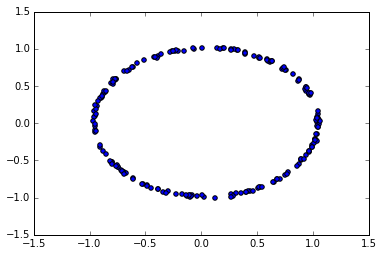

In [156]:
pylab.scatter(res['x_est'][:, 0], res['x_est'][:, 1])

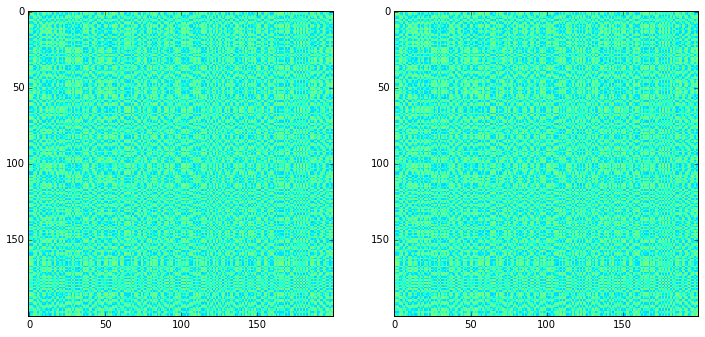

In [157]:
# predict missing values
obs_est = obs_forward(kern_f(res['x_est']))
VMIN = 0
VMAX = 2
f = pylab.figure(figsize=(12,6))
ax = f.add_subplot(1, 2, 1)

ax.imshow(obs_est, interpolation='nearest', vmin=VMIN, vmax=VMAX)

ax = f.add_subplot(1, 2, 2)

ax.imshow(obs, interpolation='nearest', vmin=VMIN, vmax=VMAX)



35952
35952


(0, 100)

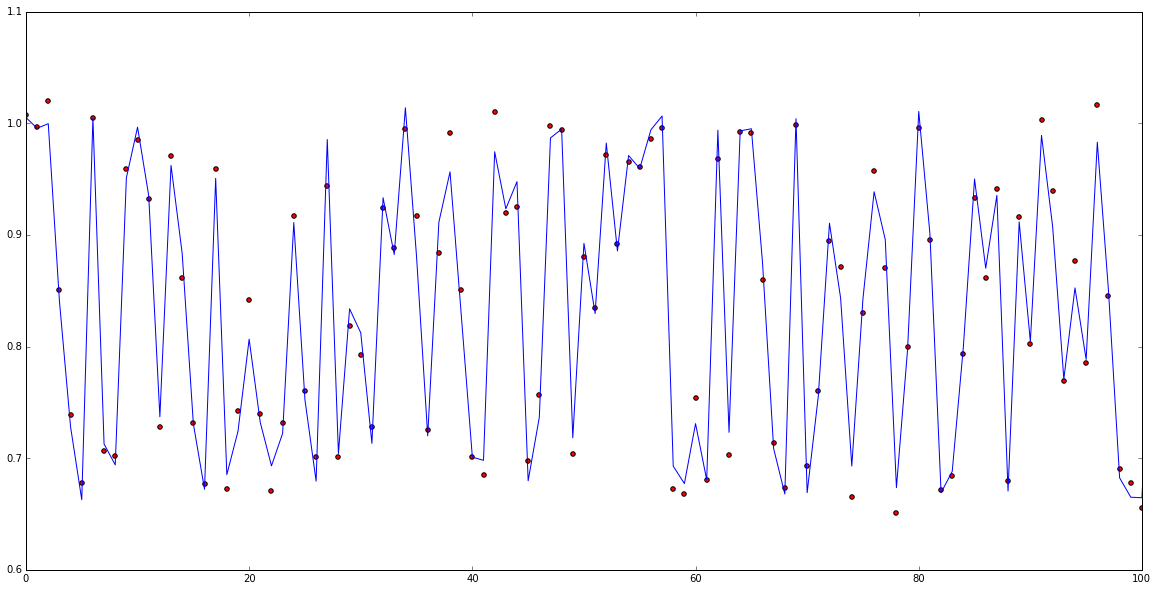

In [158]:
missing_pos = np.argwhere(obsvalid < 1)
true_vals = obs[missing_pos[:, 0], missing_pos[:, 1]]
est_vals = obs_est[missing_pos[:, 0], missing_pos[:, 1]]
print len(true_vals)
print len(est_vals)
pylab.figure(figsize=(20, 10))
pylab.plot(true_vals)
pylab.scatter(range(len(est_vals)), est_vals, c='r')
pylab.xlim(0, 100)

In [162]:
# cross-validation

reload(sgd)

#xtrue = np.random.normal(0, 1, (N, D))
xtrue = topogen.sample_sphere(N, D) + np.random.normal(0, 0.01, (N, D))

obs = obs_forward(kern_f(xtrue))

ITERS = 500

alpha = 0.01

deltas = []
for oi, obsvalid in enumerate(util.kfoldgen((N, N), 10)):

    xinit = np.random.normal(0, 1, (N, D))


    res = sgd.run_sgd_full(kern_func, log_likelihood_func, 
                     xinit, obs, obsvalid, 
                     alpha=alpha, iters=ITERS, verbose=False, verbose_iter=100)

    obs_est = obs_forward(kern_f(res['x_est']))
    
    missing_pos = np.argwhere(obsvalid  == False)
    true_vals = obs[missing_pos[:, 0], missing_pos[:, 1]]
    est_vals = obs_est[missing_pos[:, 0], missing_pos[:, 1]]
    delta = true_vals - est_vals
    print oi, np.mean(delta**2)
    deltas.append(np.mean(delta**2))

0 0.000203640882733
1 0.00020451984215
2 0.000201960855981
3 0.000202114986801
4 0.000206408597061
5 0.000203849316791
6 0.000205119806864
7 0.000204610171282
8 0.000190916925253
9 0.000209214918862


In [163]:
reload(exputil)
xinit = np.random.normal(0, 1, (N, D))


ITERS = 500

alpha = 0.01
KFOLD = 10

res = exputil.run_cv_exp(kern_func, log_likelihood_func, 
                     xinit, obs, obs_forward, KFOLD,  #batch_size=30, 
                     alpha=alpha, iters=ITERS, verbose=False, verbose_iter=1000)
r = res[0]
for r in res:
    print r['cfold_i'], np.mean((r['est_vals'] - r['true_vals'])**2)


0 0.000210329862357
1 0.000200627597055
2 0.000197787110518
3 0.000206034177456
4 0.000208736213581
5 0.000203852145296
6 0.000204806593961
7 0.000195779204925
8 0.00020202149953
9 0.000204799123383


# Poisson Likelihood

In [78]:

reload(sgd)
N = 400
D = 2
BW = 3.0

def kern_func(X):
    translation_vectors = X.reshape((X.shape[0], 1, -1)) - X.reshape((1, X.shape[0], -1))
    euclidean_dist2 = ((translation_vectors) ** 2).sum(2) 
    kern = T.exp(-euclidean_dist2/BW)
    return kern

def make_kern_f(kern_func):
    X = T.dmatrix('X')
    return theano.function([X], kern_func(X))


POI_SCALE = 4.0
def log_likelihood_func(obs, theta):
    return obs * T.log(POI_SCALE * theta) - POI_SCALE * theta - T.gammaln(obs+1)


def obs_forward(x):
    """
    go from kernel val to observations
    """
    return np.random.poisson(POI_SCALE * x)

kern_f = make_kern_f(kern_func)

#xtrue = np.random.normal(0, 1, (N, D))
xtrue = topogen.sample_sphere(N, D) + np.random.normal(0, 0.01, (N, D))

obs = obs_forward(kern_f(xtrue))

obs_frac = 0.98
obsvalid = np.random.rand(*obs.shape) < obs_frac

xinit = np.random.normal(0, 1, (N, D))


ITERS = 10000

alpha = 0.01

res = sgd.run_sgd_full(kern_func, log_likelihood_func, 
                 xinit, obs, obsvalid, batch_size=70, use_adagrad=False,
                 alpha=alpha, iters=ITERS, verbose=True, verbose_iter=200)



0 obj= -426372.582356 ||grad||= 1314.6657265 ||x||= 24.6530509671 0.00
200 obj= -271268.394861 ||grad||= 150.702552607 ||x||= 19.9459451421 0.00
400 obj= -271146.103865 ||grad||= 176.782225212 ||x||= 20.064737731 0.00
600 obj= -271249.831258 ||grad||= 160.415417254 ||x||= 20.2664107361 0.01
800 obj= -271351.182352 ||grad||= 137.607185807 ||x||= 19.9252666845 0.01
1000 obj= -271151.818277 ||grad||= 162.899723396 ||x||= 20.0346236031 0.01
1200 obj= -271526.42359 ||grad||= 171.63093348 ||x||= 19.7495736938 0.01
1400 obj= -271478.37501 ||grad||= 168.34567965 ||x||= 19.7267760242 0.01
1600 obj= -271478.960913 ||grad||= 173.170769626 ||x||= 19.9119485404 0.02
1800 obj= -271307.185014 ||grad||= 159.556031477 ||x||= 20.1919456763 0.02
2000 obj= -271154.135338 ||grad||= 173.39837632 ||x||= 19.8779469635 0.02
2200 obj= -271300.527827 ||grad||= 162.880976202 ||x||= 20.0504577062 0.02
2400 obj= -271369.203481 ||grad||= 162.974216946 ||x||= 20.1958673103 0.02
2600 obj= -271400.951157 ||grad||= 172.

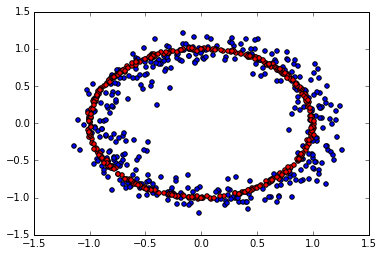

In [79]:
pylab.scatter(res['x_est'][:, 0], res['x_est'][:, 1])
pylab.scatter(xtrue[:, 0], xtrue[:, 1], c='r')

# poisson with s-curve

(400, 3)
0 obj= -395911.720838 ||grad||= 1195.02867223 ||x||= 32.0560722887 0.00
200 obj= -189731.204174 ||grad||= 134.427573182 ||x||= 33.1160232491 0.00
400 obj= -188187.917315 ||grad||= 127.470571359 ||x||= 33.1244928796 0.00
600 obj= -188280.808355 ||grad||= 145.010983599 ||x||= 32.9855720316 0.01
800 obj= -188267.760915 ||grad||= 140.329542057 ||x||= 33.0955285225 0.01
1000 obj= -188185.699298 ||grad||= 127.069034898 ||x||= 32.9214390663 0.01
1200 obj= -188238.189622 ||grad||= 123.654448076 ||x||= 33.1549825725 0.01
1400 obj= -188221.724409 ||grad||= 143.410322382 ||x||= 33.1305639716 0.01
1600 obj= -188274.852479 ||grad||= 121.689524263 ||x||= 32.8821267483 0.02
1800 obj= -188368.699346 ||grad||= 126.853011716 ||x||= 33.2422796149 0.02
2000 obj= -188315.096905 ||grad||= 148.4997623 ||x||= 33.1598716282 0.02
2200 obj= -188203.827459 ||grad||= 112.546133466 ||x||= 33.0393868159 0.02
2400 obj= -188430.401569 ||grad||= 128.091858006 ||x||= 33.1161605549 0.02
2600 obj= -188175.238806 

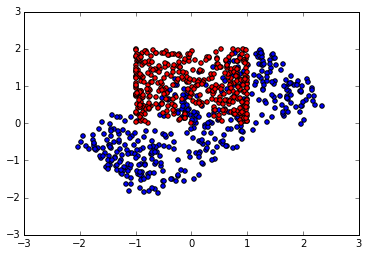

In [94]:

reload(sgd)
N = 400
D = 3
BW = 3.0

def kern_func(X):
    translation_vectors = X.reshape((X.shape[0], 1, -1)) - X.reshape((1, X.shape[0], -1))
    euclidean_dist2 = ((translation_vectors) ** 2).sum(2) 
    kern = T.exp(-euclidean_dist2/BW)
    return kern

def make_kern_f(kern_func):
    X = T.dmatrix('X')
    return theano.function([X], kern_func(X))


POI_SCALE = 4.0
def log_likelihood_func(obs, theta):
    return obs * T.log(POI_SCALE * theta) - POI_SCALE * theta - T.gammaln(obs+1)


def obs_forward(x):
    """
    go from kernel val to observations
    """
    return np.random.poisson(POI_SCALE * x)

kern_f = make_kern_f(kern_func)

#xtrue = np.random.normal(0, 1, (N, D))
#xtrue = topogen.sample_sphere(N, D) + np.random.normal(0, 0.01, (N, D))
xtrue, _ = sklearn.datasets.samples_generator.make_s_curve(N) # , D)
print xtrue.shape
obs = obs_forward(kern_f(xtrue))

obs_frac = 0.98
obsvalid = np.random.rand(*obs.shape) < obs_frac

xinit = np.random.normal(0, 1, (N, D))


ITERS = 10000

alpha = 0.01

res = sgd.run_sgd_full(kern_func, log_likelihood_func, 
                 xinit, obs, obsvalid, batch_size=70, use_adagrad=False,
                 alpha=alpha, iters=ITERS, verbose=True, verbose_iter=200)

pylab.scatter(res['x_est'][:, 0], res['x_est'][:, 1])
pylab.scatter(xtrue[:, 0], xtrue[:, 1], c='r')

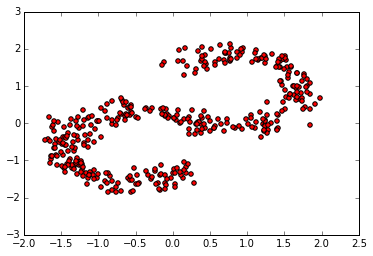

In [105]:
reload(util)

axis = [1, 1, 0.2]
theta = 1.4
x_est = res['x_est']

x_est_rot = np.dot(util.rotation_matrix(axis,theta), x_est.T).T
pylab.scatter(x_est_rot[:, 0], x_est_rot[:, 1], c='r')

# poisson cv

In [167]:

reload(sgd)
import exputil
reload(exputil)
N = 400
D = 3
BW = 3.0

def kern_func(X):
    translation_vectors = X.reshape((X.shape[0], 1, -1)) - X.reshape((1, X.shape[0], -1))
    euclidean_dist2 = ((translation_vectors) ** 2).sum(2) 
    kern = T.exp(-euclidean_dist2/BW)
    return kern

def make_kern_f(kern_func):
    X = T.dmatrix('X')
    return theano.function([X], kern_func(X))


POI_SCALE = 4.0
def log_likelihood_func(obs, theta):
    return obs * T.log(POI_SCALE * theta) - POI_SCALE * theta - T.gammaln(obs+1)


def obs_forward(x):
    """
    go from kernel val to observations
    """
    return np.random.poisson(POI_SCALE * x)

kern_f = make_kern_f(kern_func)

xtrue, _ = sklearn.datasets.samples_generator.make_s_curve(N) # , D)
print xtrue.shape
obs = obs_forward(kern_f(xtrue))


xinit = np.random.normal(0, 1, (N, D))


ITERS = 100000

alpha = 0.001
KFOLD = 10

res = exputil.run_cv_exp(kern_func, log_likelihood_func, 
                     xinit, obs, obs_forward, KFOLD,  batch_size=30, 
                     alpha=alpha, iters=ITERS, verbose=False, verbose_iter=1000)



(400, 3)


In [168]:
r = res[0]
for r in res:
    print r['cfold_i'], np.mean((r['est_vals'] - r['true_vals'])**2)

0 2.6380625
1 2.618875
2 2.682375
3 2.7373125
4 2.646
5 2.717
6 2.63575
7 2.693125
8 2.7094375
9 2.58475
